<a href="https://colab.research.google.com/github/AnuragSingh7292/Remote-sensing-image-retrieval-deep-learning-/blob/main/matrices%26Pre-Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running, follow the authentication steps

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MAP

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load extracted features and labels for VGG16
# save_dir = "/content/drive/MyDrive/NewONeFeature_IFK_Vectors"
# save_dir = "/content/drive/MyDrive/NewONeFeature_VGG_Vectors"
# save_dir = "/content/drive/MyDrive/NewONeFeature_PCA_PrePro_Vectors"

# save_dir = "/content/drive/MyDrive/resnet_features_patternNet_vectors"

save_dir = "/content/drive/MyDrive"


features = np.load(f"{save_dir}/resnet101_fc6_32_NLM_HE_features.npy")
labels = np.load(f"{save_dir}/labelNLM.npy")

# Compute Mean Average Precision (MAP)
def compute_map(features, labels):
    num_images = features.shape[0]
    similarity_matrix = cosine_similarity(features)  # Compute cosine similarity
    average_precisions = []

    for i in range(num_images):
        query_label = labels[i]
        similarities = similarity_matrix[i]

        # Sort images by similarity (descending order) and exclude self-match
        sorted_indices = np.argsort(-similarities)
        sorted_indices = sorted_indices[sorted_indices != i]  # Remove self-
        # sorted_indices = np.delete(sorted_indices, np.where(sorted_indices == i))  # More robust
        sorted_labels = labels[sorted_indices]

        # Compute relevance scores (1 if label matches, else 0)
        relevant_items = (sorted_labels == query_label).astype(int)
        num_relevant = np.sum(relevant_items)

        # If no relevant items exist, AP is 0
        if num_relevant == 0:
            average_precisions.append(0)
            continue

        # Compute precision at each rank
        cumulative_relevance = np.cumsum(relevant_items)
        precision_at_k = cumulative_relevance / (np.arange(len(relevant_items)) + 1)

        # Compute Average Precision (AP)
        average_precision = np.sum(precision_at_k * relevant_items) / num_relevant
        average_precisions.append(average_precision)

    # Compute Mean Average Precision (MAP)
    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

# Compute and print MAP for VGG16
map_score = compute_map(features, labels)
print(f"✅ MAP for combine ResNet 50&101 : {map_score * 100:.2f}%")  # Convert to percentage


✅ MAP for combine ResNet 50&101 : 53.34%


ANMRR

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def compute_anmrr(labels, distance_matrix):
    num_images = len(labels)
    anmrr_values = []

    for i in range(num_images):
        # Sort indices based on distance (ascending order)
        sorted_indices = np.argsort(distance_matrix[i])
        sorted_indices = sorted_indices[sorted_indices != i]  # Exclude self-match

        # Retrieve the sorted labels
        sorted_labels = labels[sorted_indices]

        # Identify relevant items
        relevant_items = (sorted_labels == labels[i])
        num_relevant = np.sum(relevant_items)

        if num_relevant == 0:
            anmrr_values.append(1)  # Worst case if no relevant images found
            continue

        # Compute rank positions of relevant items
        rank_positions = np.where(relevant_items)[0] + 1  # Convert to 1-based indexing

        # Compute Modified Retrieval Rank (MRR)
        mrr = np.sum(rank_positions) / num_relevant

        # Compute Normalized Modified Retrieval Rank (NMRR)
        # K = min(2 * num_relevant, num_images)  # Dynamic cut-off based on relevant items
        K = num_images  # Since we are considering all images
        nmrr = (mrr - 0.5 * (1 + num_relevant)) / (1.25 * K - 0.5 * (1 + num_relevant))

        anmrr_values.append(nmrr)

    # Mean of NMRR values
    anmrr = np.mean(anmrr_values)
    return anmrr


# Compute and print ANMRR for each model (all images)

features = np.load(f"/content/drive/MyDrive/NewONeFeature_PCA_PrePro_Vectors/resnet101_fc6_32_NLM_HE_features.npy")
labels = np.load(f"/content/drive/MyDrive/NewONeFeature_PCA_PrePro_Vectors/labelNLM.npy")

# Compute distance matrix efficiently using cdist (Euclidean distance)
distance_matrix = cdist(features, features, metric='euclidean')

# Compute ANMRR for all images
anmrr_score = compute_anmrr(labels, distance_matrix)
print(f"ANMRR for combine  ResNet 50&101 : {anmrr_score:.4f}")


ANMRR for combine  ResNet 50&101 : 0.0742


from here all Pre-Processing method to  make images more enhanced

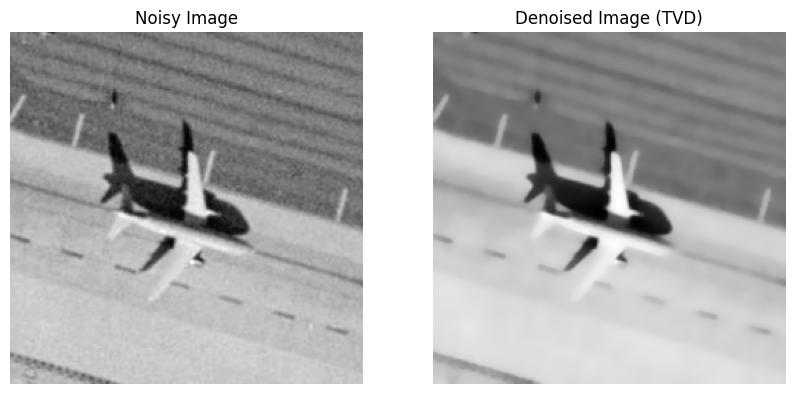

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.restoration import denoise_tv_chambolle

# Load the noisy image
image = img_as_float(io.imread('/content/airplane02.tif', as_gray=True))

# Apply Total Variation Denoising
lambda_param = 0.1  # Regularization parameter
denoised_image = denoise_tv_chambolle(image, weight=lambda_param)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Noisy Image")
ax[0].axis("off")

ax[1].imshow(denoised_image, cmap='gray')
ax[1].set_title("Denoised Image (TVD)")
ax[1].axis("off")

plt.show()

In [ ]:
# !pip install rembg pillow
# !apt-get install -y libglib2.0-0

!pip install rembg onnxruntime pillow



from rembg import remove
from PIL import Image

# Load image
input_image = Image.open("/content/airplane02.tif")

# Remove background
output_image = remove(input_image)

# Save result
output_image.show()
output_image.save("output.png")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 150GB/s]


In [ ]:
imshow("/content/output.png")

NameError: name 'imshow' is not defined

In [ ]:
# !pip install rembg onnxruntime pillow
# !apt-get install -y libglib2.0-0

from rembg import remove
from PIL import Image
import cv2
import numpy as np

def preprocess_image_with_bg_removal(img_path, target_size=(224, 224)):
    # Load image
    input_image = Image.open(img_path)

    # Remove background
    output_image = remove(input_image)

    # Convert to numpy array for further processing
    img = np.array(output_image)

    # Resize image
    img = cv2.resize(img, target_size)  # Resize image

    # Convert to RGB (if not already in RGB format)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)  # Convert RGBA to RGB if needed

    return img

# Example usage:
processed_image = preprocess_image_with_bg_removal("/content/airplane02.tif")

# Optionally, show and save the result
output_pil_image = Image.fromarray(processed_image)
output_pil_image.show()
output_pil_image.save("processed_output.png")


In [ ]:
# !pip install rembg onnxruntime pillow
# !apt-get install -y libglib2.0-0

from rembg import remove
from PIL import Image
import cv2
import numpy as np

def preprocess_image_with_white_background(img_path, target_size=(224, 224)):
    # Load image
    input_image = Image.open(img_path)

    # Remove background
    output_image = remove(input_image)

    # Convert to numpy array for further processing
    img = np.array(output_image)

    # If the image has an alpha channel (RGBA), replace transparent areas with white
    if img.shape[2] == 4:
        # Extract the alpha channel
        alpha_channel = img[:, :, 3]
        # Create a white background
        white_background = np.ones_like(img[:, :, :3]) * 255  # All white

        # Replace transparent areas with white
        img = np.dstack((white_background, alpha_channel))

        # Convert to RGB (discard alpha channel)
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Resize image
    img = cv2.resize(img, target_size)  # Resize image

    return img

# Example usage:
processed_image = preprocess_image_with_white_background("/content/airplane02.tif")

# Optionally, show and save the result
output_pil_image = Image.fromarray(processed_image)
output_pil_image.show()
output_pil_image.save("processed_output_white_background.png")


In [ ]:
# !pip install rembg onnxruntime pillow
# !apt-get install -y libglib2.0-0

from rembg import remove
from PIL import Image
import cv2
import numpy as np

def preprocess_image_with_white_background(img_path, target_size=(224, 224)):
    # Load image
    input_image = Image.open(img_path)

    # Remove background
    output_image = remove(input_image)

    # Convert to numpy array for further processing
    img = np.array(output_image)

    # If the image has an alpha channel (RGBA), replace transparent areas with white
    if img.shape[2] == 4:
        # Extract the alpha channel
        alpha_channel = img[:, :, 3]
        # Create a white background
        white_background = np.ones_like(img[:, :, :3]) * 255  # All white

        # Replace transparent areas with white
        img = np.dstack((white_background, alpha_channel))

        # Convert to RGB (discard alpha channel)
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Resize image
    img = cv2.resize(img, target_size)  # Resize image

    return img

# Example usage:
processed_image = preprocess_image_with_white_background("/content/airplane02.tif")

# Optionally, show and save the result
output_pil_image = Image.fromarray(processed_image)
output_pil_image.show()
output_pil_image.save("processed_output_white_background.png")


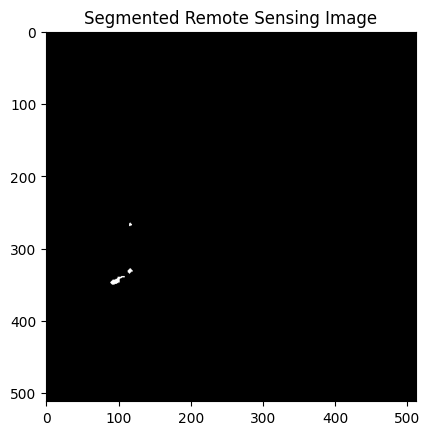

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load pretrained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Load image
image = Image.open("/content/airplane03.tif")
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((512, 512))])
input_tensor = transform(image).unsqueeze(0)

# Run segmentation
with torch.no_grad():
    output = model(input_tensor)['out']
segmented = output.argmax(1).squeeze().numpy()

# Display result
plt.imshow(segmented, cmap="gray")
plt.title("Segmented Remote Sensing Image")
plt.show()

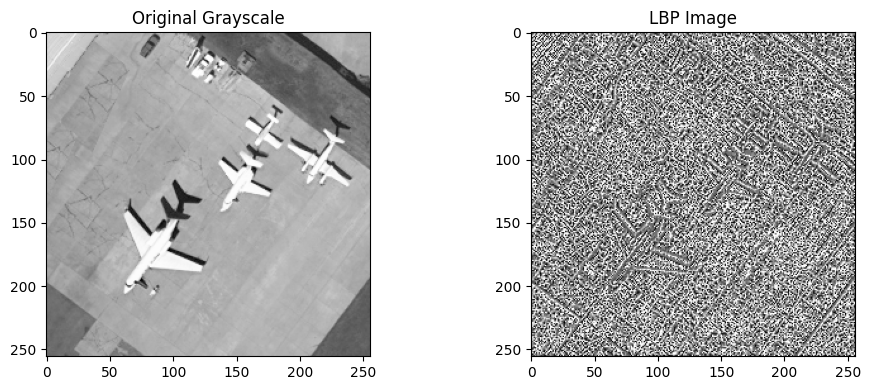

LBP Tensor shape: torch.Size([1, 3, 224, 224])


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import torch
from torchvision import transforms

# LBP parameters
radius = 1
n_points = 8 * radius
method = 'uniform'

# Load image and convert to grayscale
img_path = '/content/airplane00.tif'  # Change this to your image path
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply LBP
lbp = local_binary_pattern(gray, n_points, radius, method)

# Normalize to [0, 255]
lbp_norm = np.uint8(255 * lbp / lbp.max())

# Optional: Show original and LBP
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Grayscale")
plt.imshow(gray, cmap='gray')
plt.subplot(1,2,2)
plt.title("LBP Image")
plt.imshow(lbp_norm, cmap='gray')
plt.tight_layout()
plt.show()

# Prepare for model input
# ResNet expects 3 channels, so we replicate LBP to make it 3-channel
lbp_3ch = np.stack([lbp_norm]*3, axis=-1)

# Transform to tensor and normalize like ImageNet
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean
                         [0.229, 0.224, 0.225])  # Std
])

# Convert to tensor
lbp_tensor = transform(lbp_3ch)

# Add batch dimension
lbp_tensor = lbp_tensor.unsqueeze(0)  # Shape: [1, 3, 224, 224]

# Ready to feed into model
print("LBP Tensor shape:", lbp_tensor.shape)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.1 MB/s eta 0:00:00


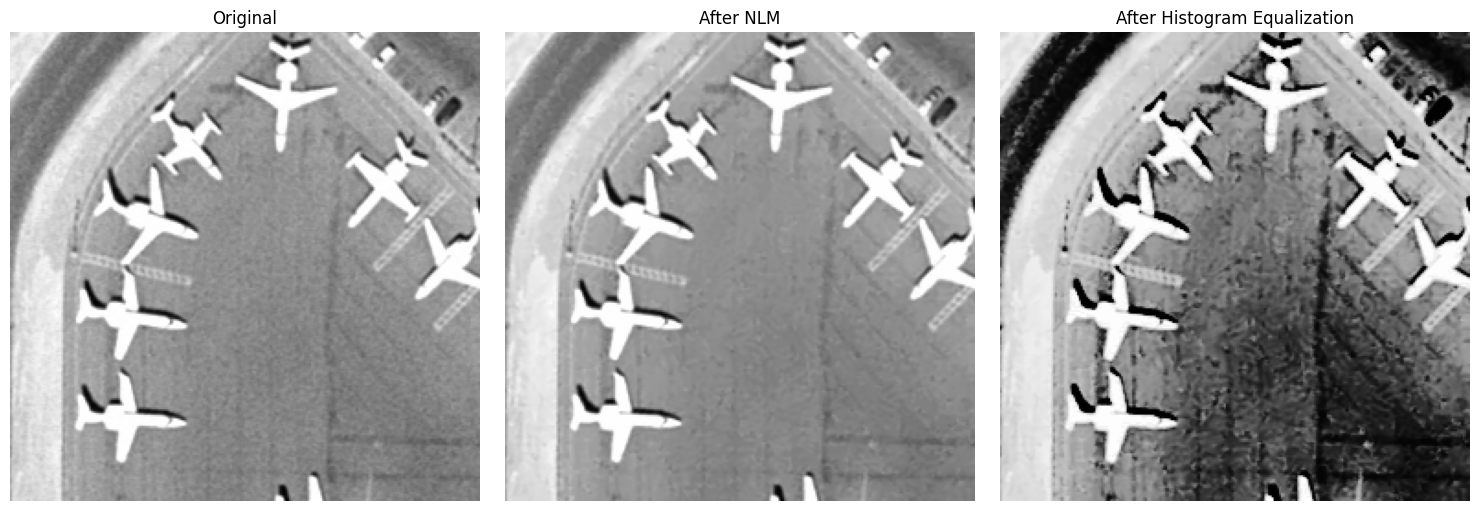

In [ ]:

!pip install PyWavelets

from skimage import io, img_as_float, img_as_ubyte
from skimage.restoration import denoise_nl_means, estimate_sigma
import cv2
import matplotlib.pyplot as plt

# Load grayscale image and convert to float
image = img_as_float(io.imread('/content/airplane38.tif', as_gray=True))

# Estimate noise
sigma_est = estimate_sigma(image, average_sigmas=True)

# Apply NLM denoising
denoised_nlm = denoise_nl_means(
    image,
    h=1.15 * sigma_est,
    fast_mode=True,
    patch_size=5,
    patch_distance=6,
    #multichannel=False
)

# Convert to uint8 for histogram equalization
denoised_uint8 = img_as_ubyte(denoised_nlm)

# Apply Histogram Equalization using OpenCV
equalized = cv2.equalizeHist(denoised_uint8)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('After NLM')
plt.imshow(denoised_uint8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('After Histogram Equalization')
plt.imshow(equalized, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()